# LOADING THE DATASETS

In [1]:
import pandas as pd
import numpy as np

In [2]:
movies=pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
ratings=pd.read_csv("ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


# Visualising the data

In [6]:
ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False).head(10)

movieId
53355     5.0
96608     5.0
33138     5.0
128087    5.0
3851      5.0
160644    5.0
126921    5.0
3939      5.0
3940      5.0
3941      5.0
Name: rating, dtype: float64

In [7]:
ratings.groupby('movieId')['rating'].count().sort_values(ascending=False)

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
57502       1
57522       1
57526       1
4032        1
193609      1
Name: rating, Length: 9724, dtype: int64

In [8]:
ratings_count=pd.DataFrame(ratings.groupby('movieId').agg({'rating':np.mean}))
ratings_count.reset_index()
ratings_count.head()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429


In [9]:
ratings_count['No. of Ratings']=pd.DataFrame(ratings.groupby('movieId')['rating'].count())
ratings_count.head()

,rating,No. of Ratings
movieId,,
1,3.920930,215
2,3.431818,110
3,3.259615,52
4,2.357143,7
5,3.071429,49


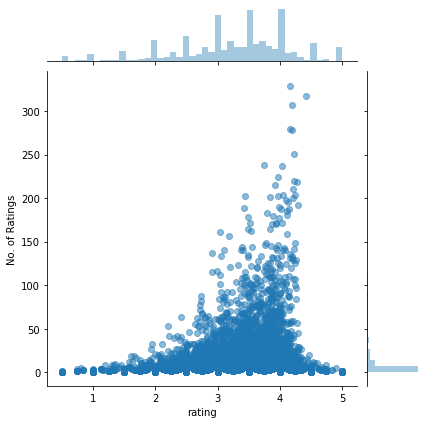

In [11]:
import seaborn as sns
sns.jointplot(x='rating',y='No. of Ratings',data=ratings_count,alpha=0.5)

#### From the graph we can tell that where ever the points are dense, that is the most number of ratings that has been given by the users. 

# 1.	Creating recommender system using only ratings dataset

In [12]:
movie_rating_count=(ratings.groupby('movieId')['rating'].count().reset_index().rename(columns={'rating':'TotalCount'})[['movieId','TotalCount']])
movie_rating_count.head()

,movieId,TotalCount
0,1,215
1,2,110
2,3,52
3,4,7
4,5,49


In [13]:
#movie_rating_count.sort_values('TotalCount',ascending=False)

In [14]:
ratings_with_count=ratings.merge(movie_rating_count,left_on='movieId',right_on='movieId',how='left')
ratings_with_count.head(10)

,userId,movieId,rating,timestamp,TotalCount
0,1,1,4.0,964982703,215
1,1,3,4.0,964981247,52
2,1,6,4.0,964982224,102
3,1,47,5.0,964983815,203
4,1,50,5.0,964982931,204
5,1,70,3.0,964982400,55
6,1,101,5.0,964980868,23
7,1,110,4.0,964982176,237
8,1,151,5.0,964984041,44
9,1,157,5.0,964984100,11


In [15]:
popularity_threshold=50
ratings_popular_movies=ratings_with_count.query('TotalCount >= @popularity_threshold')
ratings_popular_movies.head(10)

,userId,movieId,rating,timestamp,TotalCount
0,1,1,4.0,964982703,215
1,1,3,4.0,964981247,52
2,1,6,4.0,964982224,102
3,1,47,5.0,964983815,203
4,1,50,5.0,964982931,204
5,1,70,3.0,964982400,55
7,1,110,4.0,964982176,237
10,1,163,5.0,964983650,66
12,1,223,3.0,964980985,104
13,1,231,5.0,964981179,133


#### Keeping only those movies which has been rated by more than 50 users

In [16]:
ratings_matrix=(ratings_popular_movies.pivot(index='movieId',columns='userId',values='rating')).fillna(0)
ratings_matrix.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
6,4.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0
7,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0


In [17]:
from scipy.sparse import csr_matrix
ratings_csr=csr_matrix(ratings_matrix.values)
ratings_csr

<450x606 sparse matrix of type '<class 'numpy.float64'>'
	with 41360 stored elements in Compressed Sparse Row format>

In [18]:
from sklearn.neighbors import NearestNeighbors
knn=NearestNeighbors(metric='cosine',algorithm='brute')
knn.fit(ratings_csr)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [19]:
query_index=np.random.choice(ratings_matrix.shape[0])
print(query_index)
distances,indices=knn.kneighbors(ratings_matrix.iloc[query_index,:].values.reshape(1,-1),n_neighbors=6)

404


In [20]:
for i in range(0,len(distances.flatten())):
    if i==0:
        print('Recommendation for {0}:\n'.format(ratings_matrix.index[query_index]))
    else:
        print('{0}: {1} with distances of {2}:'.format(i,ratings_matrix.index[indices.flatten()[i]],distances.flatten()[i]))

Recommendation for 48780:

1: 48516 with distances of 0.3903629416827662:
2: 33794 with distances of 0.39379522842943715:
3: 44191 with distances of 0.42925628643389735:
4: 4226 with distances of 0.44936564847932414:
5: 58559 with distances of 0.45372708576971377:


# Displaying predicted rating for a particular userID and MovieID combinations (both taken as keyboard input)

In [21]:
from surprise import KNNWithMeans, Dataset, accuracy, Reader, SVD
from surprise.model_selection import train_test_split

In [22]:
ratings_new=ratings.copy()

In [23]:
ratings_new.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [24]:
ratings_new=ratings_new.drop('timestamp',axis=1)

In [25]:
reader=Reader(rating_scale=(1,5))
data=Dataset.load_from_df(ratings_new,reader)

In [26]:
[trainset,testset]=train_test_split(data,test_size=0.2,shuffle=True)

In [27]:
recom=KNNWithMeans(k=50,sim_options={'name':'cosine','user_based':True})
recom.fit(data.build_full_trainset())
test_pred=recom.test(testset)
RMSE=accuracy.rmse(test_pred)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.7786


In [28]:
#test_pred

In [29]:
print('Please enter User_Id')
ui=int(input())
print('Please enter Movie_Id')
iid=int(input())
pre=recom.predict(ui,iid)
print('The rating value for item', iid, 'by user',ui, 'is: ',pre[3])

Please enter User_Id
67
Please enter Movie_Id
34
The rating value for item 34 by user 67 is:  4.1701531132599285


# 3. Recommend a user to watch top 10 movies, which he has not watched yet (as per his rating predictions). 

#### movies that selected user id has watched and has rated the movie more than 4

In [30]:
print('Please select any User_Id')
uid=int(input())
df_user = ratings_new[(ratings_new['userId'] == uid) & (ratings_new['rating'] > 4)]
df_user = df_user.set_index('movieId')
df_user = df_user.join(movies)['title']
df_user = pd.DataFrame(df_user)
#df_user.reset_index()
df_user.head()

Please select any User_Id
88


,title
movieId,
16,Sense and Sensibility (1995)
50,Georgia (1995)
223,Kiss of Death (1995)
318,I Love Trouble (1994)
1193,Event Horizon (1997)


In [31]:
movies_not_considered=list(df_user.index)
movies_not_considered

[16,
 50,
 223,
 318,
 1193,
 1732,
 1884,
 2542,
 3275,
 3476,
 4262,
 4878,
 4963,
 4993,
 4995,
 5418,
 5952,
 5995,
 6502,
 6870,
 6874,
 7153,
 7438,
 8665,
 8950,
 44191,
 48394,
 48774,
 54286,
 55820,
 56782,
 58559,
 68157,
 79132]

In [32]:
user=movies.copy()
user.reset_index()
user= user[~user['movieId'].isin(movies_not_considered)]
pre = list(user['movieId'].apply(lambda x: recom.predict(uid, x)))

In [33]:
#pre

In [34]:
pred_rating=[]
for Prediction in pre:
    pred_rating.append(Prediction.est)
#pred_rating

In [35]:
user['Estimate_Score']=pred_rating
user= user.sort_values('Estimate_Score', ascending=False)
user.head(10)

,movieId,title,genres,Estimate_Score
4122,5919,Android (1982),Sci-Fi,5.0
4083,5833,Dog Soldiers (2002),Action|Horror,5.0
4050,5764,Looker (1981),Drama|Horror|Sci-Fi|Thriller,5.0
4054,5772,My Dinner with André (1981),Drama,5.0
9061,142196,Cornered! (2009),Comedy|Horror,5.0
9068,142444,The Editor (2015),Comedy|Horror|Mystery,5.0
9075,142550,Ryuzo and the Seven Henchmen (2015),Action|Comedy,5.0
7905,95165,Dragon Ball Z the Movie: The World's Strongest...,Action|Adventure|Animation|Sci-Fi|Thriller,5.0
7903,95149,Superman/Batman: Public Enemies (2009),Action|Animation|Fantasy,5.0
9079,142831,Garam Masala (2005),Comedy,5.0
